In [5]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image, clear_output
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [6]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


In [7]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


In [8]:
images = []
from random import randint
for dir_name, dirs, files in os.walk('.\\notMNIST_large'):
    if len(files) > 0 and dir_name != '.\\notMNIST_large':
        img_path = dir_name+'\\'+files[randint(0, len(files)-1)]
        images.append(img_path)
for image in images:
    display(Image(filename=image))

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

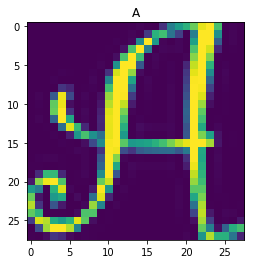

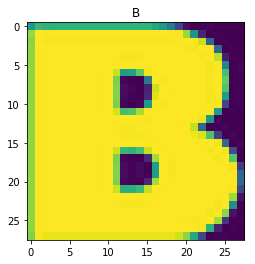

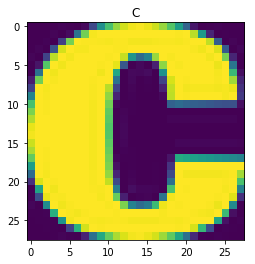

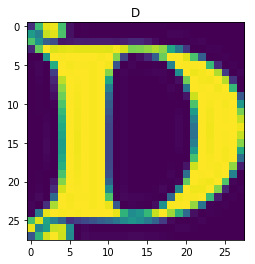

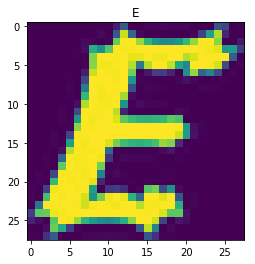

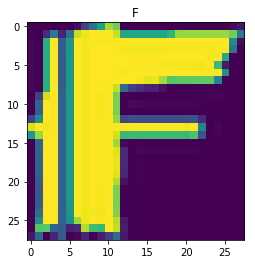

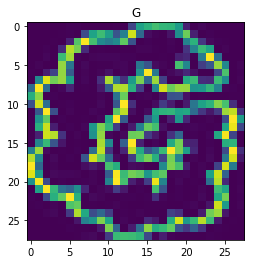

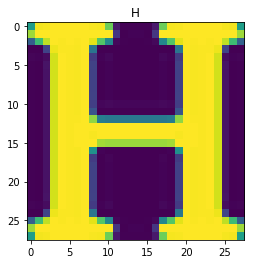

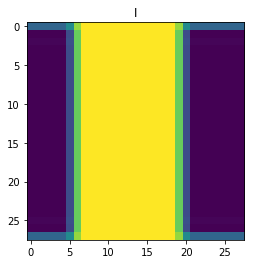

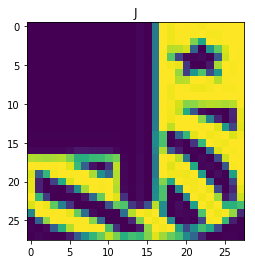

In [10]:
for train_dataset in train_datasets:
    with open(train_dataset, "rb") as f:
        dataset = pickle.load(f)
        image = dataset[randint(0, len(dataset)-1), :, :] * 255 + 127.5
        plt.title(os.path.splitext(os.path.basename(os.path.normpath(train_dataset)))[0])
        plt.imshow(image)
        plt.show()

In [11]:
number_of_images = []
for train_dataset in train_datasets:
    with open(train_dataset, "rb") as f:
        dataset = pickle.load(f)
        title = os.path.splitext(os.path.basename(os.path.normpath(train_dataset)))[0]
        print(title + ":", len(dataset))
        number_of_images.append(len(dataset))
print("Standard Deviation", np.std(number_of_images))
print("Variance", np.var(number_of_images))

A: 52909


B: 52911


C: 52912


D: 52911


E: 52912


F: 52912


G: 52912


H: 52912


I: 52912


J: 52911
Standard Deviation 0.916515138991
Variance 0.84


In [12]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [13]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [14]:
nb_divisions = 10
for i in range(0, nb_divisions):
    number_of_images_by_class = [0] * len(train_datasets)
    for j in range(i*int(len(train_dataset)/nb_divisions), (i+1)*int(len(train_dataset)/nb_divisions)):
        number_of_images_by_class[train_labels[j]] += 1
    print(np.std(number_of_images_by_class))

40.2243707222
49.2808279151
31.8370852937
41.5283036013
50.6181785528
41.6749325134
29.0585615611
23.0260721792
32.8176781628
34.4122071364


In [15]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [16]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


In [39]:
def mse(image1, image2):
    err = np.sum((image1 - image2) ** 2)
    err /= float(image1.shape[0] * image1.shape[1])
    return err

def show_difference(image1, image2):
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.show()

overlapped_train_dataset_indices = []
sanitized_test_dataset = test_dataset
sanitized_valid_dataset = valid_dataset

from IPython.display import clear_output
progress_percent = 0
for train_index, train_image in enumerate(train_dataset):

    to_be_removed_from_test_dataset = []
    for test_index, test_image in enumerate(sanitized_test_dataset):
        if train_labels[train_index] != test_labels[test_index]:
            continue
        error = mse(train_image, test_image)
        if error < 0.01:
            to_be_removed_from_test_dataset.append(test_index)
            if train_index not in overlapped_train_dataset_indices:
                overlapped_train_dataset_indices.append(train_index)
    sanitized_test_dataset = [val
                              for index, val in enumerate(sanitized_test_dataset)
                              if index not in to_be_removed_from_test_dataset]

    to_be_removed_from_valid_dataset = []
    for valid_index, test_image in enumerate(sanitized_valid_dataset):
        if train_labels[train_index] != valid_labels[valid_index]:
            continue
        error = mse(train_image, test_image)
        if error < 0.01:
            to_be_removed_from_valid_dataset.append(valid_index)
            if train_index not in overlapped_train_dataset_indices:
                overlapped_train_dataset_indices.append(train_index)
    sanitized_valid_dataset = [val
                              for index, val in enumerate(sanitized_valid_dataset)
                              if index not in to_be_removed_from_valid_dataset]

    if train_index == int((progress_percent+1) * len(train_dataset)/1000)-1:
        progress_percent += 1
        print('%0.1f' % (progress_percent/10)+"% completed")

print()
print("Removed entries")
print("Test Dataset: ", len(test_dataset) - len(sanitized_test_dataset))
print("Valid Dataset: ", len(valid_dataset) - len(sanitized_valid_dataset))
print("Overlapped element in train_dataset: ", len(overlapped_train_dataset_indices))

0.1% completed


0.2% completed


0.3% completed


0.4% completed


0.5% completed


0.6% completed


0.7% completed


0.8% completed


0.9% completed


1.0% completed


1.1% completed


1.2% completed


1.3% completed


1.4% completed


1.5% completed


1.6% completed


1.7% completed


1.8% completed


1.9% completed


2.0% completed


2.1% completed


2.2% completed


2.3% completed


2.4% completed


2.5% completed


2.6% completed


2.7% completed


2.8% completed


2.9% completed


3.0% completed


3.1% completed


3.2% completed


3.3% completed


3.4% completed


3.5% completed


3.6% completed


3.7% completed


3.8% completed


3.9% completed


4.0% completed


4.1% completed


4.2% completed


4.3% completed


4.4% completed


4.5% completed


4.6% completed


4.7% completed


4.8% completed


4.9% completed


5.0% completed


5.1% completed


5.2% completed


5.3% completed


5.4% completed


5.5% completed


5.6% completed


5.7% completed


5.8% completed


5.9% completed


6.0% completed


6.1% completed


6.2% completed


6.3% completed


6.4% completed


6.5% completed


6.6% completed


6.7% completed


6.8% completed


6.9% completed


7.0% completed


7.1% completed


7.2% completed


7.3% completed


7.4% completed


7.5% completed


7.6% completed


7.7% completed


7.8% completed


7.9% completed


8.0% completed


8.1% completed


8.2% completed


8.3% completed


8.4% completed


8.5% completed


8.6% completed


8.7% completed


8.8% completed


8.9% completed


9.0% completed


9.1% completed


9.2% completed


9.3% completed


9.4% completed


9.5% completed


9.6% completed


9.7% completed


9.8% completed


9.9% completed


10.0% completed


10.1% completed


10.2% completed


10.3% completed


10.4% completed


10.5% completed


10.6% completed


10.7% completed


10.8% completed


10.9% completed


11.0% completed


11.1% completed


11.2% completed


11.3% completed


11.4% completed


11.5% completed


11.6% completed


11.7% completed


11.8% completed


11.9% completed


12.0% completed


12.1% completed


12.2% completed


12.3% completed


12.4% completed


12.5% completed


12.6% completed


12.7% completed


12.8% completed


12.9% completed


13.0% completed


13.1% completed


13.2% completed


13.3% completed


13.4% completed


13.5% completed


13.6% completed


13.7% completed


13.8% completed


13.9% completed


14.0% completed


14.1% completed


14.2% completed


14.3% completed


14.4% completed


14.5% completed


14.6% completed


14.7% completed


14.8% completed


14.9% completed


15.0% completed


15.1% completed


15.2% completed


15.3% completed


15.4% completed


15.5% completed


15.6% completed


15.7% completed


15.8% completed


15.9% completed


16.0% completed


16.1% completed


16.2% completed


16.3% completed


16.4% completed


16.5% completed


16.6% completed


16.7% completed


16.8% completed


16.9% completed


17.0% completed


17.1% completed


17.2% completed


17.3% completed


17.4% completed


17.5% completed


17.6% completed


17.7% completed


17.8% completed


17.9% completed


18.0% completed


18.1% completed


18.2% completed


18.3% completed


18.4% completed


18.5% completed


18.6% completed


18.7% completed


18.8% completed


18.9% completed


19.0% completed


19.1% completed


19.2% completed


19.3% completed


19.4% completed


19.5% completed


19.6% completed


19.7% completed


19.8% completed


19.9% completed


20.0% completed


20.1% completed


20.2% completed


20.3% completed


20.4% completed


20.5% completed


20.6% completed


20.7% completed


20.8% completed


20.9% completed


21.0% completed


21.1% completed


21.2% completed


21.3% completed


21.4% completed


21.5% completed


21.6% completed


21.7% completed


21.8% completed


21.9% completed


22.0% completed


22.1% completed


22.2% completed


22.3% completed


22.4% completed


22.5% completed


22.6% completed


22.7% completed


22.8% completed


22.9% completed


23.0% completed


23.1% completed


23.2% completed


23.3% completed


23.4% completed


23.5% completed


23.6% completed


23.7% completed


23.8% completed


23.9% completed


24.0% completed


24.1% completed


24.2% completed


24.3% completed


24.4% completed


24.5% completed


24.6% completed


24.7% completed


24.8% completed


24.9% completed


25.0% completed


25.1% completed


25.2% completed


25.3% completed


25.4% completed


25.5% completed


25.6% completed


25.7% completed


25.8% completed


25.9% completed


26.0% completed


26.1% completed


26.2% completed


26.3% completed


26.4% completed


26.5% completed


26.6% completed


26.7% completed


26.8% completed


26.9% completed


27.0% completed


27.1% completed


27.2% completed


27.3% completed


27.4% completed


27.5% completed


27.6% completed


27.7% completed


27.8% completed


27.9% completed


28.0% completed


28.1% completed


28.2% completed


28.3% completed


28.4% completed


28.5% completed


28.6% completed


28.7% completed


28.8% completed


28.9% completed


29.0% completed


29.1% completed


29.2% completed


29.3% completed


29.4% completed


29.5% completed


29.6% completed


29.7% completed


29.8% completed


29.9% completed


30.0% completed


30.1% completed


30.2% completed


30.3% completed


30.4% completed


30.5% completed


30.6% completed


30.7% completed


30.8% completed


30.9% completed


31.0% completed


31.1% completed


31.2% completed


31.3% completed


31.4% completed


31.5% completed


31.6% completed


31.7% completed


31.8% completed


31.9% completed


32.0% completed


32.1% completed


32.2% completed


32.3% completed


32.4% completed


32.5% completed


32.6% completed


32.7% completed


32.8% completed


32.9% completed


33.0% completed


33.1% completed


33.2% completed


33.3% completed


33.4% completed


33.5% completed


33.6% completed


33.7% completed


33.8% completed


33.9% completed


34.0% completed


34.1% completed


34.2% completed


34.3% completed


34.4% completed


34.5% completed


34.6% completed


34.7% completed


34.8% completed


34.9% completed


35.0% completed


35.1% completed


35.2% completed


35.3% completed


35.4% completed


35.5% completed


35.6% completed


35.7% completed


35.8% completed


35.9% completed


36.0% completed


36.1% completed


36.2% completed


36.3% completed


36.4% completed


36.5% completed


36.6% completed


36.7% completed


36.8% completed


36.9% completed


37.0% completed


37.1% completed


37.2% completed


37.3% completed


37.4% completed


37.5% completed


37.6% completed


37.7% completed


37.8% completed


37.9% completed


38.0% completed


38.1% completed


38.2% completed


38.3% completed


38.4% completed


38.5% completed


38.6% completed


38.7% completed


38.8% completed


38.9% completed


39.0% completed


39.1% completed


39.2% completed


39.3% completed


39.4% completed


39.5% completed


39.6% completed


39.7% completed


39.8% completed


39.9% completed


40.0% completed


40.1% completed


40.2% completed


40.3% completed


40.4% completed


40.5% completed


40.6% completed


40.7% completed


40.8% completed


40.9% completed


41.0% completed


41.1% completed


41.2% completed


41.3% completed


41.4% completed


41.5% completed


41.6% completed


41.7% completed


41.8% completed


41.9% completed


42.0% completed


42.1% completed


42.2% completed


42.3% completed


42.4% completed


42.5% completed


42.6% completed


42.7% completed


42.8% completed


42.9% completed


43.0% completed


43.1% completed


43.2% completed


43.3% completed


43.4% completed


43.5% completed


43.6% completed


43.7% completed


43.8% completed


43.9% completed


44.0% completed


44.1% completed


44.2% completed


44.3% completed


44.4% completed


44.5% completed


44.6% completed


44.7% completed


44.8% completed


44.9% completed


45.0% completed


45.1% completed


45.2% completed


45.3% completed


45.4% completed


45.5% completed


45.6% completed


45.7% completed


45.8% completed


45.9% completed


46.0% completed


46.1% completed


46.2% completed


46.3% completed


46.4% completed


46.5% completed


46.6% completed


46.7% completed


46.8% completed


46.9% completed


47.0% completed


47.1% completed


47.2% completed


47.3% completed


47.4% completed


47.5% completed


47.6% completed


47.7% completed


47.8% completed


47.9% completed


48.0% completed


48.1% completed


48.2% completed


48.3% completed


48.4% completed


48.5% completed


48.6% completed


48.7% completed


48.8% completed


48.9% completed


49.0% completed


49.1% completed


49.2% completed


49.3% completed


49.4% completed


49.5% completed


49.6% completed


49.7% completed


49.8% completed


49.9% completed


50.0% completed


50.1% completed


50.2% completed


50.3% completed


50.4% completed


50.5% completed


50.6% completed


50.7% completed


50.8% completed


50.9% completed


51.0% completed


51.1% completed


51.2% completed


51.3% completed


51.4% completed


51.5% completed


51.6% completed


51.7% completed


51.8% completed


51.9% completed


52.0% completed


52.1% completed


52.2% completed


52.3% completed


52.4% completed


52.5% completed


52.6% completed


52.7% completed


52.8% completed


52.9% completed


53.0% completed


53.1% completed


53.2% completed


53.3% completed


53.4% completed


53.5% completed


53.6% completed


53.7% completed


53.8% completed


53.9% completed


54.0% completed


54.1% completed


54.2% completed


54.3% completed


54.4% completed


54.5% completed


54.6% completed


54.7% completed


54.8% completed


54.9% completed


55.0% completed


55.1% completed


55.2% completed


55.3% completed


55.4% completed


55.5% completed


55.6% completed


55.7% completed


55.8% completed


55.9% completed


56.0% completed


56.1% completed


56.2% completed


56.3% completed


56.4% completed


56.5% completed


56.6% completed


56.7% completed


56.8% completed


56.9% completed


57.0% completed


57.1% completed


57.2% completed


57.3% completed


57.4% completed


57.5% completed


57.6% completed


57.7% completed


57.8% completed


57.9% completed


58.0% completed


58.1% completed


58.2% completed


58.3% completed


58.4% completed


58.5% completed


58.6% completed


58.7% completed


58.8% completed


58.9% completed


59.0% completed


59.1% completed


59.2% completed


59.3% completed


59.4% completed


59.5% completed


59.6% completed


59.7% completed


59.8% completed


59.9% completed


60.0% completed


60.1% completed


60.2% completed


60.3% completed


60.4% completed


60.5% completed


60.6% completed


60.7% completed


60.8% completed


60.9% completed


61.0% completed


61.1% completed


61.2% completed


61.3% completed


61.4% completed


61.5% completed


61.6% completed


61.7% completed


61.8% completed


61.9% completed


62.0% completed


62.1% completed


62.2% completed


62.3% completed


62.4% completed


62.5% completed


62.6% completed


62.7% completed


62.8% completed


62.9% completed


63.0% completed


63.1% completed


63.2% completed


63.3% completed


63.4% completed


63.5% completed


63.6% completed


63.7% completed


63.8% completed


63.9% completed


64.0% completed


64.1% completed


64.2% completed


64.3% completed


64.4% completed


64.5% completed


64.6% completed


64.7% completed


64.8% completed


64.9% completed


65.0% completed


65.1% completed


65.2% completed


65.3% completed


65.4% completed


65.5% completed


65.6% completed


65.7% completed


65.8% completed


65.9% completed


66.0% completed


66.1% completed


66.2% completed


66.3% completed


66.4% completed


66.5% completed


66.6% completed


66.7% completed


66.8% completed


66.9% completed


67.0% completed


67.1% completed


67.2% completed


67.3% completed


67.4% completed


67.5% completed


67.6% completed


67.7% completed


67.8% completed


67.9% completed


68.0% completed


68.1% completed


68.2% completed


68.3% completed


68.4% completed


68.5% completed


68.6% completed


68.7% completed


68.8% completed


68.9% completed


69.0% completed


69.1% completed


69.2% completed


69.3% completed


69.4% completed


69.5% completed


69.6% completed


69.7% completed


69.8% completed


69.9% completed


70.0% completed


70.1% completed


70.2% completed


70.3% completed


70.4% completed


70.5% completed


70.6% completed


70.7% completed


70.8% completed


70.9% completed


71.0% completed


71.1% completed


71.2% completed


71.3% completed


71.4% completed


71.5% completed


71.6% completed


71.7% completed


71.8% completed


71.9% completed


72.0% completed


72.1% completed


72.2% completed


72.3% completed


72.4% completed


72.5% completed


72.6% completed


72.7% completed


72.8% completed


72.9% completed


73.0% completed


73.1% completed


73.2% completed


73.3% completed


73.4% completed


73.5% completed


73.6% completed


73.7% completed


73.8% completed


73.9% completed


74.0% completed


74.1% completed


74.2% completed


74.3% completed


74.4% completed


74.5% completed


74.6% completed


74.7% completed


74.8% completed


74.9% completed


75.0% completed


75.1% completed


75.2% completed


75.3% completed


75.4% completed


75.5% completed


75.6% completed


75.7% completed


75.8% completed


75.9% completed


76.0% completed


76.1% completed


76.2% completed


76.3% completed


76.4% completed


76.5% completed


76.6% completed


76.7% completed


76.8% completed


76.9% completed


77.0% completed


77.1% completed


77.2% completed


77.3% completed


77.4% completed


77.5% completed


77.6% completed


77.7% completed


77.8% completed


77.9% completed


78.0% completed


78.1% completed


78.2% completed


78.3% completed


78.4% completed


78.5% completed


78.6% completed


78.7% completed


78.8% completed


78.9% completed


79.0% completed


79.1% completed


79.2% completed


79.3% completed


79.4% completed


79.5% completed


79.6% completed


79.7% completed


79.8% completed


79.9% completed


80.0% completed


80.1% completed


80.2% completed


80.3% completed


80.4% completed


80.5% completed


80.6% completed


80.7% completed


80.8% completed


80.9% completed


81.0% completed


81.1% completed


81.2% completed


81.3% completed


81.4% completed


81.5% completed


81.6% completed


81.7% completed


81.8% completed


81.9% completed


82.0% completed


82.1% completed


82.2% completed


82.3% completed


82.4% completed


82.5% completed


82.6% completed


82.7% completed


82.8% completed


82.9% completed


83.0% completed


83.1% completed


83.2% completed


83.3% completed


83.4% completed


83.5% completed


83.6% completed


83.7% completed


83.8% completed


83.9% completed


84.0% completed


84.1% completed


84.2% completed


84.3% completed


84.4% completed


84.5% completed


84.6% completed


84.7% completed


84.8% completed


84.9% completed


85.0% completed


85.1% completed


85.2% completed


85.3% completed


85.4% completed


85.5% completed


85.6% completed


85.7% completed


85.8% completed


85.9% completed


86.0% completed


86.1% completed


86.2% completed


86.3% completed


86.4% completed


86.5% completed


86.6% completed


86.7% completed


86.8% completed


86.9% completed


87.0% completed


87.1% completed


87.2% completed


87.3% completed


87.4% completed


87.5% completed


87.6% completed


87.7% completed


87.8% completed


87.9% completed


88.0% completed


88.1% completed


88.2% completed


88.3% completed


88.4% completed


88.5% completed


88.6% completed


88.7% completed


88.8% completed


88.9% completed


89.0% completed


89.1% completed


89.2% completed


89.3% completed


89.4% completed


89.5% completed


89.6% completed


89.7% completed


89.8% completed


89.9% completed


90.0% completed


90.1% completed


90.2% completed


90.3% completed


90.4% completed


90.5% completed


90.6% completed


90.7% completed


90.8% completed


90.9% completed


91.0% completed


91.1% completed


91.2% completed


91.3% completed


91.4% completed


91.5% completed


91.6% completed


91.7% completed


91.8% completed


91.9% completed


92.0% completed


92.1% completed


92.2% completed


92.3% completed


92.4% completed


92.5% completed


92.6% completed


92.7% completed


92.8% completed


92.9% completed


93.0% completed


93.1% completed


93.2% completed


93.3% completed


93.4% completed


93.5% completed


93.6% completed


93.7% completed


93.8% completed


93.9% completed


94.0% completed


94.1% completed


94.2% completed


94.3% completed


94.4% completed


94.5% completed


94.6% completed


94.7% completed


94.8% completed


94.9% completed


95.0% completed


95.1% completed


95.2% completed


95.3% completed


95.4% completed


95.5% completed


95.6% completed


95.7% completed


95.8% completed


95.9% completed


96.0% completed


96.1% completed


96.2% completed


96.3% completed


96.4% completed


96.5% completed


96.6% completed


96.7% completed


96.8% completed


96.9% completed


97.0% completed


97.1% completed


97.2% completed


97.3% completed


97.4% completed


97.5% completed


97.6% completed


97.7% completed


97.8% completed


97.9% completed


98.0% completed


98.1% completed


98.2% completed


98.3% completed


98.4% completed


98.5% completed


98.6% completed


98.7% completed


98.8% completed


98.9% completed


99.0% completed


99.1% completed


99.2% completed


99.3% completed


99.4% completed


99.5% completed


99.6% completed


99.7% completed


99.8% completed


99.9% completed


100.0% completed

Removed entries
Test Dataset:  2234
Valid Dataset:  1852
Overlapped element in train_dataset:  3571
